# preprocessing

In [1]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt

In [2]:
# load data
data_dir = "data/"

college_players_stats = pd.read_csv(f'{data_dir}college_players_stats.csv', index_col=0)
drafted_players = pd.read_csv(f'{data_dir}drafted_players.csv', index_col=0)
not_drafted = pd.read_csv(f'{data_dir}not_drafted.csv', index_col=0)
players_stats = pd.read_csv(f'{data_dir}players_stats.csv', index_col=0)

# add label and normalize relevant values

players_stats['drafted'] = players_stats['name'].isin(drafted_players['name'])
players_stats['drafted'] = players_stats['drafted'].astype(int)


# add label and normalize relevant values

players_stats['drafted'] = players_stats['name'].isin(drafted_players['name'])
players_stats['drafted'] = players_stats['drafted'].astype(int)
players_stats = players_stats.drop(columns=['name'])

# discretize height
def convert_height(height_str):
    feet, inches = map(int, height_str.split('-'))
    return feet + inches / 12  

# Apply the conversion function to the height column
players_stats['height'] = players_stats['height'].apply(convert_height)

# add binary columns for each position label
def str_to_int(maybe_bool):
    if isinstance(maybe_bool, bool):
        return int(maybe_bool) 
    return maybe_bool

def weight_to_int(input):
    if(input == "22l"):
        return 221
    return(int(input)) 
players_stats['weight'] = players_stats['weight'].apply(weight_to_int)

players_stats = pd.get_dummies(players_stats, columns=['position'])
players_stats = players_stats.applymap(str_to_int)

players_stats.info()
non_numeric_columns = players_stats.select_dtypes(exclude=["number"]).columns
print("Non-numeric columns:", non_numeric_columns)

# TODO: add other metrics for training
df = players_stats

df.dropna(inplace=True)
pd.set_option('display.max_columns', None)
df.head()

/var/folders/2x/719ln_714y74dz825_4kskt40000gn/T/ipykernel_50786/1988355783.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  players_stats = players_stats.applymap(str_to_int)


<class 'pandas.core.frame.DataFrame'>
Index: 31860 entries, 0 to 31859
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   height                     31860 non-null  float64
 1   weight                     31860 non-null  int64  
 2   games_played               31860 non-null  int64  
 3   games_started              31860 non-null  int64  
 4   min_per                    31573 non-null  float64
 5   field_goal                 31860 non-null  float64
 6   field_attmps               31860 non-null  float64
 7   field_pct                  31127 non-null  float64
 8   two_pointer                31860 non-null  float64
 9   two_pattamps               31860 non-null  float64
 10  two_pct                    30592 non-null  float64
 11  three_ptrs                 31860 non-null  float64
 12  three_pattmp               31860 non-null  float64
 13  three_pct                  31127 non-null  float64


,height,weight,games_played,games_started,min_per,field_goal,field_attmps,field_pct,two_pointer,two_pattamps,two_pct,three_ptrs,three_pattmp,three_pct,free_throws,free_attmps,free_pct,assists,steals,blocks,points,off_reb,def_reb,total_reb,turnovers,drafted,position_Center,position_Center-Forward,position_Forward,position_Forward-Center,position_Forward-Guard,position_Forward-PF,position_Forward-SF,position_Forward-SF-Guard,position_Guard,position_Guard-Forward,position_Guard-PG,position_Guard-SG,position_PForward,position_PForward-F,position_PGuard,position_PGuard-G,position_SForward,position_SForward-F,position_SGuard-G
0,6.416667,215,41,19,13.3,0.9,2.1,0.414,0.9,2.0,0.429,0.0,0.1,0.414,0.7,1.2,0.529,0.1,0.4,0.3,2.4,1.3,1.7,3.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6.750000,225,115,16,11.2,1.5,2.3,0.619,1.5,2.3,0.619,0.0,0.0,0.619,0.6,0.7,0.788,0.2,0.2,0.8,3.5,0.7,1.6,2.3,0.6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6.416667,210,92,29,16.4,1.4,4.0,0.346,0.4,1.2,0.360,0.9,2.8,0.346,0.4,0.6,0.611,0.6,0.4,0.2,4.1,0.6,1.4,2.0,0.8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.666667,210,107,55,19.0,3.1,6.5,0.473,3.1,6.5,0.474,0.0,0.0,0.473,1.8,2.8,0.641,0.4,0.5,0.7,7.9,2.5,3.2,5.7,1.2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6.750000,322,86,72,24.5,4.3,7.8,0.544,4.3,7.8,0.544,0.0,0.0,0.544,2.0,4.1,0.482,0.3,0.6,0.6,10.5,3.1,4.3,7.3,1.5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
np.unique(df['drafted'], return_counts=True)

(array([0, 1]), array([27611,  1003]))

# models

In [4]:
seed = 42
epochs = 250
lr = 0.01
batch_size = 32

# get data
x = df.drop(columns=['drafted']).values
y = df['drafted'].values


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

# downsampling
#separate drafted and non-drafted 
df_drafted = df[df['drafted'] == 1]
df_non_drafted = df[df['drafted'] == 0]


# Drop 3000 random samples from non-drafted
df_non_drafted_sampled = df_non_drafted.sample(len(df_non_drafted) - 20000, random_state=seed)

df_downsampled = pd.concat([df_drafted, df_non_drafted_sampled])
x = df_downsampled.drop(columns=['drafted']).values
y = df_downsampled['drafted'].values

xd_train, xd_test, yd_train, yd_test = train_test_split(x, y, test_size=0.2, random_state=seed)



count = 0
count_tot = 0
for y1,y2 in zip(y_train, y_test):
    if(y1 == 1):
        count+=1
    if(y2 == 1):
        count+=1
    count_tot +=1

print("Count drafted:")
print(count)
print("Count not drafted:")
print(count_tot)

np.unique(y_test, return_counts=True)

count = 0
count_tot = 0
for y1,y2 in zip(yd_train, yd_test):
    if(y1 == 1):
        count+=1
    if(y2 == 1):
        count+=1
    count_tot +=1

print("Count downsample drafted:")
print(count)
print("Count downsample not drafted:")
print(count_tot)

np.unique(y_test, return_counts=True)

Count drafted:
408
Count not drafted:
5723
Count downsample drafted:
418
Count downsample not drafted:
1723


(array([0, 1]), array([5516,  207]))

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def explain(y_test, y_pred, average='weighted'):
    """Look at precision, recall etc. for the model"""
    precision = precision_score(y_test, y_pred, average=average, zero_division=0)
    recall = recall_score(y_test, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=average, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)

    print("Precision: ", precision)
    print("Recall: ", recall)    
    print("F1: ", f1)
    print("Accuracy: ", accuracy)
    print("Distribution", np.unique(y_pred, return_counts=True))

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

Logistic Regression


/opt/anaconda3/envs/varibad3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision:  0.6722176802197907
Recall:  0.5317315810308527
F1:  0.547735913668812
Accuracy:  0.9622575572252315
Distribution (array([0, 1]), array([5686,   37]))



Decision Tree
Precision:  0.5902461683590912
Recall:  0.6159582313025261
F1:  0.6010563569092177
Accuracy:  0.9363969945832605
Distribution (array([0, 1]), array([5454,  269]))



Random Forest
Precision:  0.6966819307859771
Recall:  0.513767590461477
F1:  0.5178397444295518
Accuracy:  0.9634806919447843
Distribution (array([0, 1]), array([5709,   14]))



Naive Bayes
Precision:  0.5200932897398106
Recall:  0.5941591085047275
F1:  0.2176077961440067
Accuracy:  0.24008387209505505
Distribution (array([0, 1]), array([1177, 4546]))



SVM
Precision:  0.4819150795037568
Recall:  0.5
F1:  0.4907909956401815
Accuracy:  0.9638301590075136
Distribution (array([0]), array([5723]))





/opt/anaconda3/envs/varibad3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

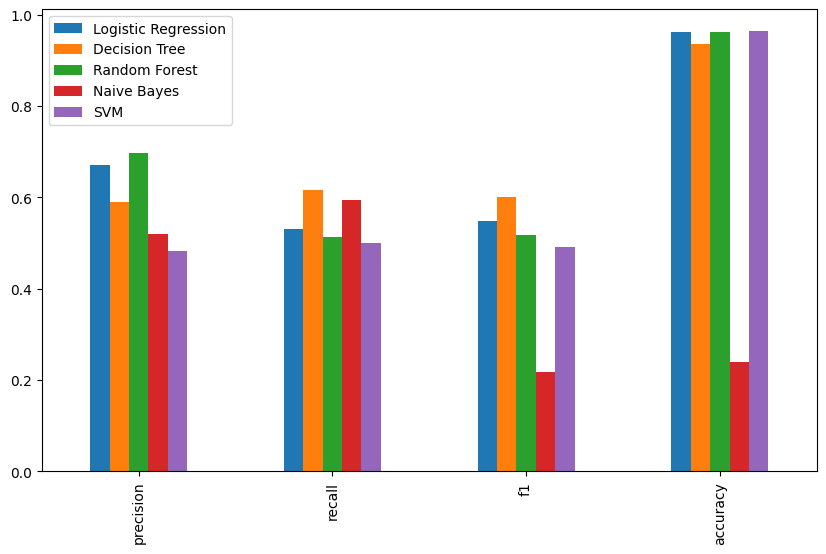

In [6]:
# scikit learn logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(random_state=seed, max_iter=250),
    "Decision Tree": DecisionTreeClassifier(random_state=seed),
    "Random Forest": RandomForestClassifier(random_state=seed),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(random_state=seed)
}

results = {}
for name, model in models.items():
    print(name)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    results[name] = explain(y_test, y_pred, average='macro')
    print("\n\n")

# plot the results as a hist
results_df = pd.DataFrame(results)
results_df.plot(kind='bar', figsize=(10, 6))

In [7]:
# WITH DOWNSAMPLED DATA

Logistic Regression


/opt/anaconda3/envs/varibad3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision:  0.7857951435537642
Recall:  0.6489143116411719
F1:  0.6878780985120402
Accuracy:  0.9001741149158444
Distribution (array([0, 1]), array([1624,   99]))



Decision Tree
Precision:  0.6326967200782366
Recall:  0.6372002203785325
F1:  0.6348785259964564
Accuracy:  0.8456181079512478
Distribution (array([0, 1]), array([1512,  211]))



Random Forest
Precision:  0.8164328203801888
Recall:  0.6586061057816956
F1:  0.7024572968455522
Accuracy:  0.905977945443993
Distribution (array([0, 1]), array([1628,   95]))



Naive Bayes
Precision:  0.5654718910272267
Recall:  0.6286670339642209
F1:  0.3722336563904751
Accuracy:  0.3900174114915844
Distribution (array([0, 1]), array([ 493, 1230]))



SVM
Precision:  0.4410911201392919
Recall:  0.5
F1:  0.4687018193031144
Accuracy:  0.8821822402785838
Distribution (array([0]), array([1723]))





/opt/anaconda3/envs/varibad3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

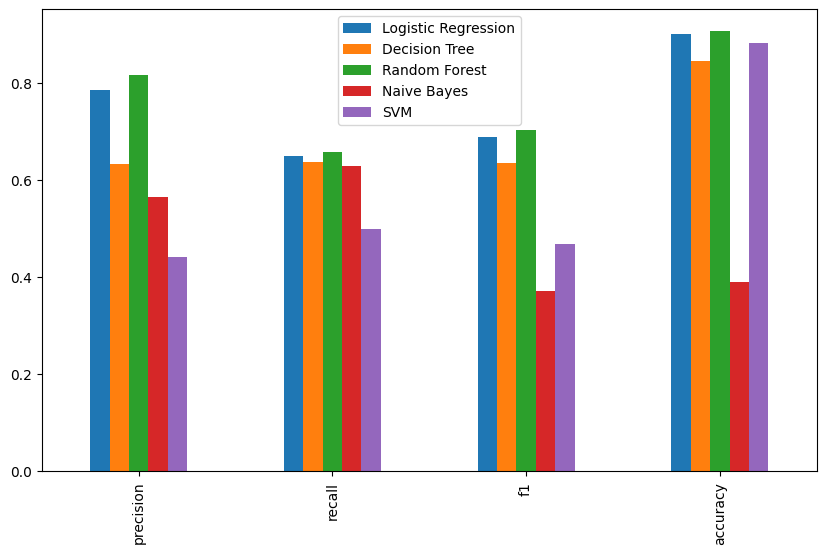

In [8]:
models = {
    "Logistic Regression": LogisticRegression(random_state=seed, max_iter=250),
    "Decision Tree": DecisionTreeClassifier(random_state=seed),
    "Random Forest": RandomForestClassifier(random_state=seed),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(random_state=seed)
}

results = {}
for name, model in models.items():
    print(name)

    model.fit(xd_train, yd_train)
    yd_pred = model.predict(xd_test)
    
    results[name] = explain(yd_test, yd_pred, average='macro')
    print("\n\n")

# plot the results as a hist
results_df = pd.DataFrame(results)
results_df.plot(kind='bar', figsize=(10, 6))

In [22]:
#NEURAL NET
from sklearn.model_selection import KFold

In [ ]:
#all data

In [19]:
# mlp
import tqdm

class MLP(torch.nn.Module):
    def __init__(self, hidden=16):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(44, hidden)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

dataset = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1))

model = MLP()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for i in tqdm.trange(epochs):
    dl = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    
    for x, y in dl:
        optimizer.zero_grad()
        output = model(x)

        loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
        loss.backward()
        optimizer.step()

  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/2x/719ln_714y74dz825_4kskt40000gn/T/ipykernel_50786/1649124460.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [01:19<00:00,  3.13it/s]


In [20]:
res = model(torch.tensor(x_test, dtype=torch.float32))

# get loss
loss = criterion(res, torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1))
loss

# get acc
predictions = [1 if x>0.5 else 0 for x in res]
acc = 1- abs(predictions - y_test).sum()/len(predictions)
print(acc)
print(sum(predictions))
print(len(predictions))

results = explain(predictions, y_test, average='macro')

0.9638301590075136
0
5723
Precision:  0.5
Recall:  0.4819150795037568
F1:  0.4907909956401815
Accuracy:  0.9638301590075136
Distribution (array([0, 1]), array([5516,  207]))


/opt/anaconda3/envs/varibad3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#DOWNSAMPLED 

In [35]:
dataset = torch.utils.data.TensorDataset(torch.tensor(xd_train, dtype=torch.float32), torch.tensor(yd_train, dtype=torch.float32).reshape(-1, 1))

model = MLP()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for i in tqdm.trange(epochs):
    dl = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    
    for x, y in dl:
        optimizer.zero_grad()
        output = model(x)

        loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
        loss.backward()
        optimizer.step()

res = model(torch.tensor(xd_test, dtype=torch.float32))

# get loss
loss = criterion(res, torch.tensor(yd_test, dtype=torch.float32).reshape(-1, 1))
loss

# get acc
predictions = [1 if x>0.5 else 0 for x in res]
acc = 1- abs(predictions - yd_test).sum()/len(predictions)
print(acc)
print(sum(predictions))
print(len(predictions))

results = explain(predictions, yd_test, average='macro')

  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/2x/719ln_714y74dz825_4kskt40000gn/T/ipykernel_50786/138103254.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
 32%|███▏      | 80/250 [00:08<00:17,  9.92it/s]


KeyboardInterrupt: 

In [36]:
# K FOLD EVALUATION ON DOWNSAMPLED
from collections import defaultdict

In [37]:

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=10)

fold_results = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(xd_train)):
    x_t, y_t = xd_train[train_idx], yd_train[train_idx]
    x_v, y_v = xd_train[test_idx], yd_train[test_idx]

    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(x_t, dtype=torch.float32),
        torch.tensor(y_t, dtype=torch.float32).reshape(-1, 1)
    )
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    model = MLP()
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

    
    val_outputs = model(torch.tensor(x_v, dtype=torch.float32))
    predictions = [1 if x>0.5 else 0 for x in val_outputs]

    results = explain(predictions, y_v, average='macro')
    fold_results.append(results)

#avg explain results across all folds

print("AVERAGE RESULTS")
print("\n\n")

#make a new dict with the avgs
countdict = defaultdict(lambda: {'sum': 0, 'count': 0})
for d in fold_results:
    for key, value in d.items():
        countdict[key]['sum'] += value
        countdict[key]['count'] += 1
averaged_dict = {key: acc['sum'] / acc['count'] for key, acc in countdict.items()}

print(averaged_dict)


Precision:  0.6784163945775524
Recall:  0.7826594435963183
F1:  0.7134508750156558
Accuracy:  0.8941261783901377
Distribution (array([0, 1]), array([1201,  178]))
Precision:  0.7592652499455936
Recall:  0.7698353911984182
F1:  0.7644034649901617
Accuracy:  0.9172714078374455
Distribution (array([0, 1]), array([1241,  137]))
Precision:  0.70940065681445
Recall:  0.792572411815314
F1:  0.741324751944221
Accuracy:  0.9085631349782293
Distribution (array([0, 1]), array([1218,  160]))
Precision:  0.6740088435883984
Recall:  0.7628532182103611
F1:  0.7054512461080145
Accuracy:  0.8962264150943396
Distribution (array([0, 1]), array([1213,  165]))
Precision:  0.6507799671592776
Recall:  0.7023064477262556
F1:  0.6707867062401525
Accuracy:  0.8817126269956459
Distribution (array([0, 1]), array([1218,  160]))
AVERAGE RESULTS



{'precision': np.float64(0.6943742224170544), 'recall': np.float64(0.7620453825093334), 'f1': np.float64(0.7190834088596411), 'accuracy': 0.8995799526591597}


Logistic Regression


/opt/anaconda3/envs/varibad3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision:  0.7857951435537642
Recall:  0.6489143116411719
F1:  0.6878780985120402
Accuracy:  0.9001741149158444
Distribution (array([0, 1]), array([1624,   99]))



Decision Tree
Precision:  0.6326967200782366
Recall:  0.6372002203785325
F1:  0.6348785259964564
Accuracy:  0.8456181079512478
Distribution (array([0, 1]), array([1512,  211]))



Random Forest
Precision:  0.8164328203801888
Recall:  0.6586061057816956
F1:  0.7024572968455522
Accuracy:  0.905977945443993
Distribution (array([0, 1]), array([1628,   95]))



Naive Bayes
Precision:  0.5654718910272267
Recall:  0.6286670339642209
F1:  0.3722336563904751
Accuracy:  0.3900174114915844
Distribution (array([0, 1]), array([ 493, 1230]))



SVM
Precision:  0.4410911201392919
Recall:  0.5
F1:  0.4687018193031144
Accuracy:  0.8821822402785838
Distribution (array([0]), array([1723]))





<Axes: >

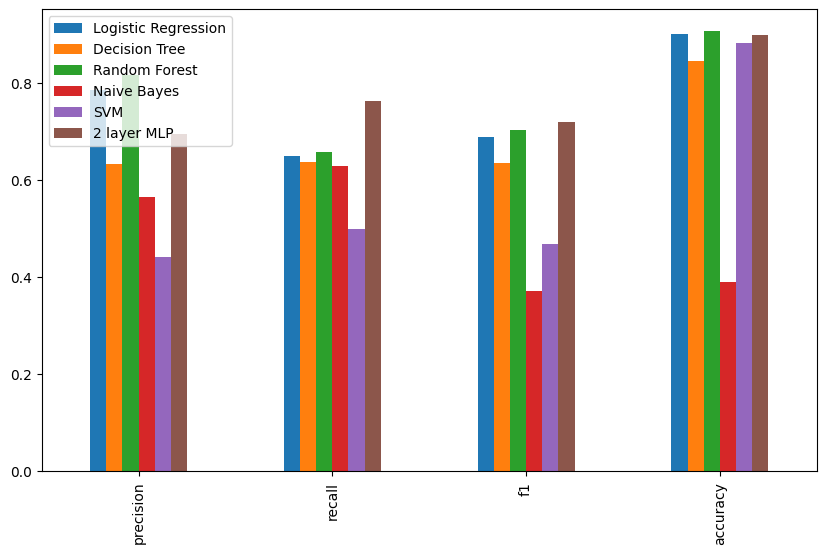

In [38]:
#TOTAL DOWNSAMPLED RESULTS
# TOTAL NON-DOWNSAMPLED RESULTS
models = {
    "Logistic Regression": LogisticRegression(random_state=seed, max_iter=250),
    "Decision Tree": DecisionTreeClassifier(random_state=seed),
    "Random Forest": RandomForestClassifier(random_state=seed),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(random_state=seed)
}

results = {}
for name, model in models.items():
    print(name)

    model.fit(xd_train, yd_train)
    yd_pred = model.predict(xd_test)
    
    results[name] = explain(yd_test, yd_pred, average='macro')
    print("\n\n")
# add the MLP
results["2 layer MLP"] = averaged_dict
# plot the results as a hist
results_df = pd.DataFrame(results)
results_df.plot(kind='bar', figsize=(10, 6))

In [ ]:
#K FOLD CROSS WITHOUT DOWNSAMPLING

In [33]:

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=20)

fold_results = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(x_train)):
    x_t, y_t = x_train[train_idx], y_train[train_idx]
    x_v, y_v = x_train[test_idx], y_train[test_idx]

    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(x_t, dtype=torch.float32),
        torch.tensor(y_t, dtype=torch.float32).reshape(-1, 1)
    )
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    model = MLP()
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

    
    val_outputs = model(torch.tensor(x_v, dtype=torch.float32))
    predictions = [1 if x>0.5 else 0 for x in val_outputs]

    results = explain(predictions, y_v, average='macro')
    fold_results.append(results)

#avg explain results across all folds

print("AVERAGE RESULTS")
print("\n\n")

#make a new dict with the avgs
countdict = defaultdict(lambda: {'sum': 0, 'count': 0})
for d in fold_results:
    for key, value in d.items():
        countdict[key]['sum'] += value
        countdict[key]['count'] += 1
averaged_dict = {key: acc['sum'] / acc['count'] for key, acc in countdict.items()}

print(averaged_dict)


Precision:  0.5
Recall:  0.4820921598602315
F1:  0.4908828107627307
Accuracy:  0.964184319720463
Distribution (array([0, 1]), array([4415,  164]))
Precision:  0.5
Recall:  0.48252512013979904
F1:  0.49110715873721655
Accuracy:  0.9650502402795981
Distribution (array([0, 1]), array([4418,  160]))
Precision:  0.5
Recall:  0.4841633901266929
F1:  0.4919542781045389
Accuracy:  0.9683267802533858
Distribution (array([0, 1]), array([4433,  145]))
Precision:  0.5
Recall:  0.48197903014416776
F1:  0.49082415749082414
Accuracy:  0.9639580602883355
Distribution (array([0, 1]), array([4413,  165]))
Precision:  0.5
Recall:  0.48230668414154654
F1:  0.49099399599733157
Accuracy:  0.9646133682830931
Distribution (array([0, 1]), array([4416,  162]))
AVERAGE RESULTS



{'precision': np.float64(0.5), 'recall': np.float64(0.4826132768824875), 'f1': np.float64(0.49115248021852836), 'accuracy': 0.965226553764975}


Logistic Regression


/opt/anaconda3/envs/varibad3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision:  0.7857951435537642
Recall:  0.6489143116411719
F1:  0.6878780985120402
Accuracy:  0.9001741149158444
Distribution (array([0, 1]), array([1624,   99]))



Decision Tree
Precision:  0.6326967200782366
Recall:  0.6372002203785325
F1:  0.6348785259964564
Accuracy:  0.8456181079512478
Distribution (array([0, 1]), array([1512,  211]))



Random Forest
Precision:  0.8164328203801888
Recall:  0.6586061057816956
F1:  0.7024572968455522
Accuracy:  0.905977945443993
Distribution (array([0, 1]), array([1628,   95]))



Naive Bayes
Precision:  0.5654718910272267
Recall:  0.6286670339642209
F1:  0.3722336563904751
Accuracy:  0.3900174114915844
Distribution (array([0, 1]), array([ 493, 1230]))



SVM
Precision:  0.4410911201392919
Recall:  0.5
F1:  0.4687018193031144
Accuracy:  0.8821822402785838
Distribution (array([0]), array([1723]))





<Axes: >

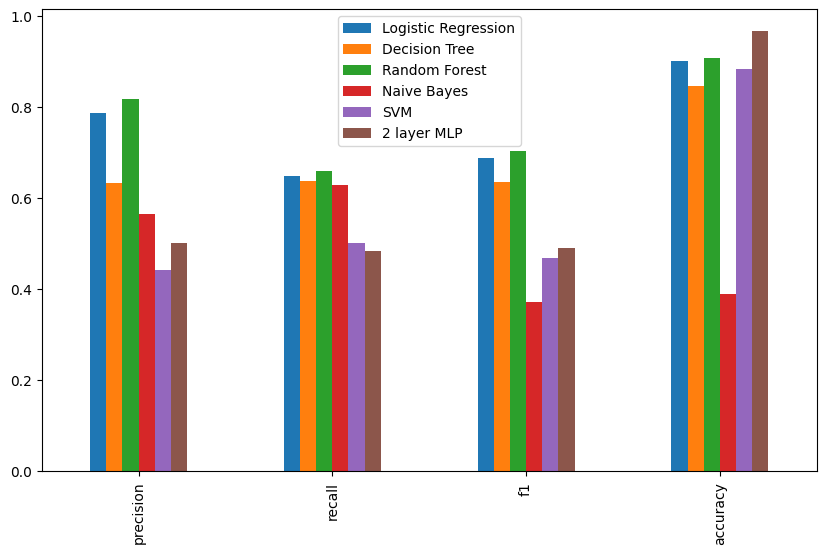

In [34]:
# TOTAL NON-DOWNSAMPLED RESULTS
models = {
    "Logistic Regression": LogisticRegression(random_state=seed, max_iter=250),
    "Decision Tree": DecisionTreeClassifier(random_state=seed),
    "Random Forest": RandomForestClassifier(random_state=seed),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(random_state=seed)
}

results = {}
for name, model in models.items():
    print(name)

    model.fit(xd_train, yd_train)
    yd_pred = model.predict(xd_test)
    
    results[name] = explain(yd_test, yd_pred, average='macro')
    print("\n\n")
# add the MLP
results["2 layer MLP"] = averaged_dict
# plot the results as a hist
results_df = pd.DataFrame(results)
results_df.plot(kind='bar', figsize=(10, 6))